In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, LSTM, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import os
from os.path import join
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import gc
import time
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental_run_functions_eagerly(True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
raw_data = np.load('./gdrive/My Drive/animefaces/data.npy')

In [0]:
raw_data = raw_data / 255.

In [0]:
test_data = raw_data[-3000:]
raw_data = raw_data[:60000]

gc.collect()

33

In [0]:
latent_dim = 100
hldim = int((3 * 64 * 64 * latent_dim) ** 0.5) * 2
#hldim = 512

inp = Input((64, 64, 3))
x = tf.keras.layers.Flatten()(inp)
x = Dense((hldim), 'relu')(x)
x = Dense((hldim), 'relu')(x)
x = Dense(latent_dim * 2)(x)
encoder_model = Model(inp, x)

inp = Input(latent_dim)
x = Dense((hldim), 'relu')(inp)
x = Dense((hldim), 'relu')(x)
x = Dense(64 * 64 * 3, 'sigmoid')(x)
x = Reshape((64, 64, 3))(x)
decoder_model = Model(inp, x)

opt = tf.keras.optimizers.SGD()

encoder_model.summary()
decoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 2216)              27232424  
_________________________________________________________________
dense_1 (Dense)              (None, 2216)              4912872   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               443400    
Total params: 32,588,696
Trainable params: 32,588,696
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Out

In [0]:
latent_dim = 100

In [0]:
encoder_model = load_model('./gdrive/My Drive/animefaces/encoder_model_new_6201.h5')
decoder_model = load_model('./gdrive/My Drive/animefaces/decoder_model_new_6201.h5')

In [0]:
@tf.function
def train_on_batch(batch, optimizer):
    with tf.GradientTape() as tape:
        tv = decoder_model.trainable_variables + encoder_model.trainable_variables
        tape.watch(tv)
        pred = encoder_model(batch)
        mid = pred[:,:latent_dim]
        logsigm = pred[:,latent_dim:]
        #mid, logsigm = tf.split(pred, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mid.shape)
        pred_mid = eps * tf.exp((logsigm - 1) * .5) + mid
        pred = decoder_model(pred_mid)
        L0 = tf.reduce_mean(tf.keras.losses.MSE(batch, pred)) * 100
        L1 = tf.keras.backend.mean((tf.exp(logsigm) - 1. - logsigm) * 1.0 + tf.square(mid))
        L = L0 + L1
    grad = tape.gradient(L, tv)
    optimizer.apply_gradients(zip(grad, tv))
    return L

train_on_batch(train_final[0], opt)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4011421>

In [0]:
opt = tf.keras.optimizers.Adam()

In [0]:
opt.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [0]:
train_final = raw_data[:(raw_data.shape[0] // 2 ** 14) * 2 ** 14].reshape(-1, 2 ** 14, 64, 64, 3)
print(train_final.shape)

(3, 16384, 64, 64, 3)


In [ ]:
import time
benchmark = []
for power in tqdm(range(13, 16)):
  batch_size_tmp = 2 ** power
  begin = time.time()
  for i in tqdm(range(raw_data.shape[0] // batch_size_tmp)):
    train_on_batch(raw_data[i * batch_size_tmp:(i + 1) * batch_size_tmp], opt)
  end = time.time()
  benchmark.append(end - begin)
plt.plot(benchmark)

begin


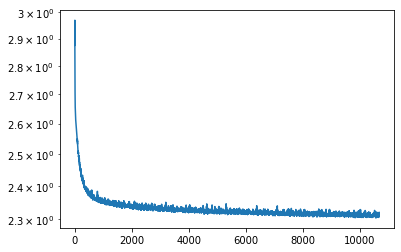

In [0]:
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
min_loss = 10 ** 100
cnt = 0
for cycle in range(100000000):
  for i in range(train_final.shape[0]):
    #print(1)
    err = train_on_batch(train_final[i], opt).numpy()
  losses.append(err)
  #print(2)
  if cycle % 2 == 0:
    clear_output(wait=True)
    print('begin')
    plt.semilogy(losses)
    plt.show()
  if cycle % 200 == 0:
    encoder_model.save('./gdrive/My Drive/animefaces/encoder_model_new_{0}.h5'.format(len(losses)))
    decoder_model.save('./gdrive/My Drive/animefaces/decoder_model_new_{0}.h5'.format(len(losses)))
    print('end')
  if cycle % 2 == 0 and False:
    clear_output(wait=True)


    test_ = decoder_model(encoder_model(test_data)[:,:latent_dim]).numpy()
    min_loss = err
    img = decoder_model((encoder_model(raw_data[2:3])[0,:latent_dim]).numpy().reshape(1, latent_dim)).numpy().reshape(64, 64, 3)
    print(np.mean(tf.keras.losses.MSE(test_, test_data)), err)
    test = encoder_model.predict(raw_data[:1000])
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.subplot(2, 1, 2)
    plt.imshow(raw_data[2])
    plt.show()
    #axes = plt.gca()
    #axes.set_xlim([-0.0001,0.0001])
    #axes.set_ylim([-0.00005,0.00005])
    plt.scatter((test[:,0]), (test[:,1]))
    plt.show()
    plt.grid()
    plt.semilogy(losses)
    plt.show()
    print(err)

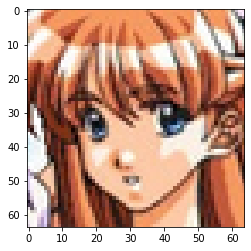

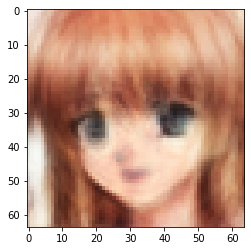

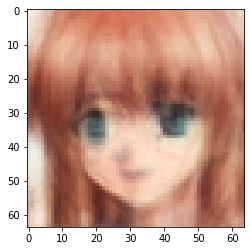

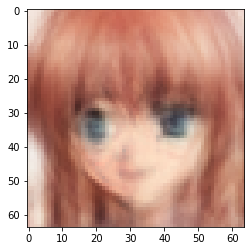

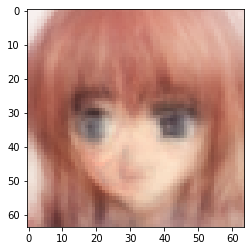

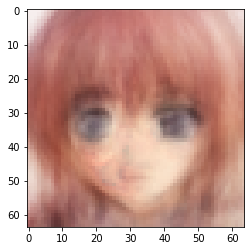

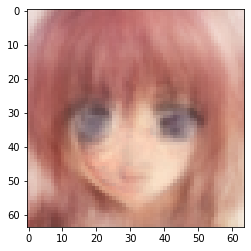

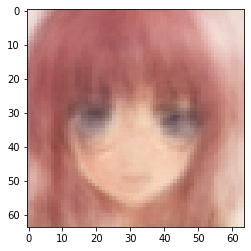

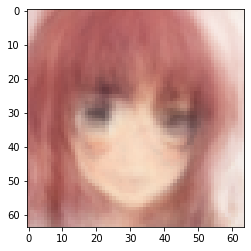

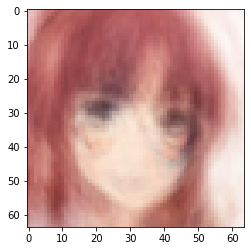

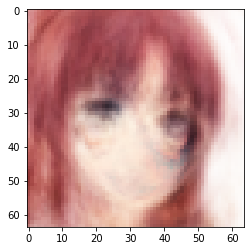

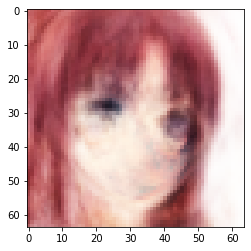

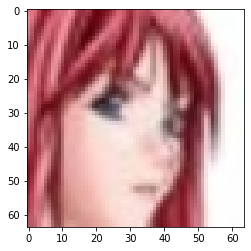

In [0]:
last_id = 12
five = encoder_model.predict(raw_data[last_id:last_id + 1])[:,:latent_dim][0]
zero = encoder_model.predict(raw_data[5:6])[:,:latent_dim][0]
#print((five * 3 + zero * 7).shape)
#print(five, zero)
plt.imshow(raw_data[5])
plt.show()
for i in range(0, 11):
  v = (five * i / 10. + zero * (10 - i) / 10.).reshape(1, latent_dim)
  img = decoder_model.predict(v).reshape(64, 64, 3)
  plt.imshow(img)
  plt.show()
plt.imshow(raw_data[last_id])
plt.show()

In [0]:
vspace = encoder_model.predict(test_data[:])[:,:latent_dim]
vspace_mean = np.mean(vspace, axis=0)
#vspace_mean = vspace - vspace_mean
vspace_unmean = np.array([_ - vspace_mean for _ in vspace])

In [0]:
_, lambdas, main_vectors = np.linalg.svd(vspace_unmean)

In [0]:
lambdas = np.sqrt(lambdas)

<BarContainer object of 100 artists>

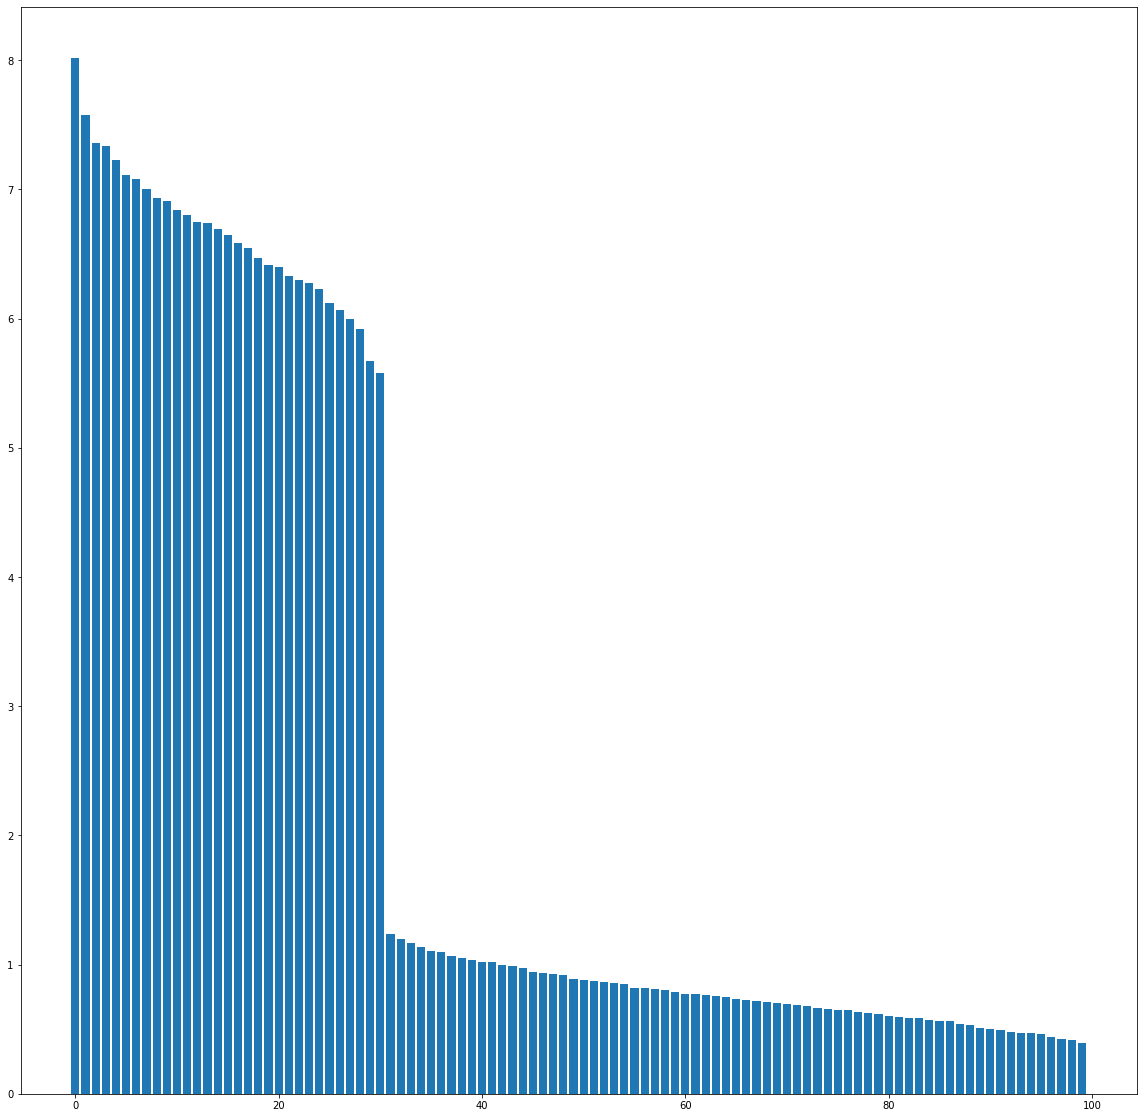

In [0]:
3



> Indented block

> Indented block

> Indented block

> Indented block

> Indented block











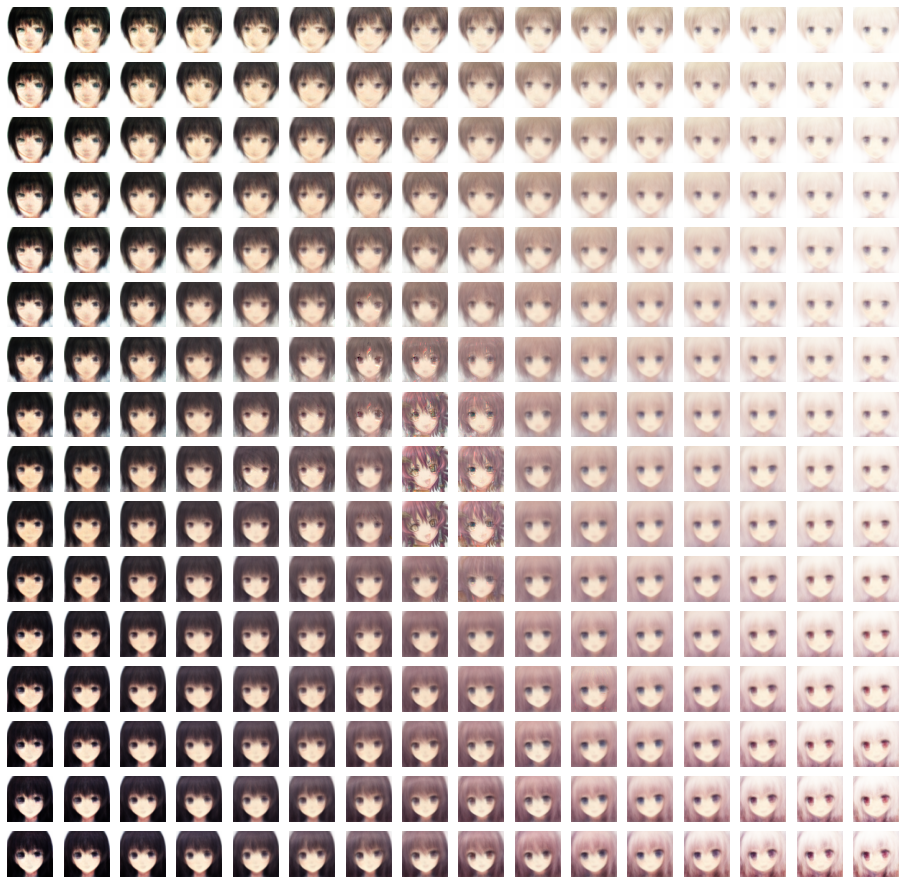

In [0]:
N = 16
fig = plt.figure(figsize=(N,N))
for i in tqdm(range(N * N)):
  plt.subplot(N, N, i+1)
  x = (i % N - N // 2) / N * 2 * main_vectors[0] * lambdas[0] * 0.5
  y = (i // N - N // 2) / N * 2 * main_vectors[2] * lambdas[2] * 0.5
  v = vspace_mean + x + y
  plt.imshow(decoder_model(v.reshape(1, latent_dim)).numpy().reshape(64, 64, 3), cmap='gray')
  plt.axis('off')

In [0]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [0]:
def show_pic(**kwargs):
  args = [(_, kwargs[_]) for _ in kwargs.keys()]
  args.sort()
  vals = np.copy(vspace_mean) #np.array([args[_][1] * lambdas[_] if _ < len(args) else 0 for _ in range(latent_dim)]) + vspace_mean
  for id_, i in enumerate(args):
    vals += main_vectors[id_] * lambdas[id_] * i[1] * 0.5
  #print(vals - vspace_mean)
  plt.imshow(decoder_model.predict(vals.reshape(1, latent_dim)).reshape(64, 64, 3), cmap='gray')
  plt.axis('off')
  plt.show()

In [0]:
interact(show_pic, x0 = (-1.,1.), x1 = (-1.,1.), x2 = (-1.,1.), x3 = (-1.,1.), x4 = (-1.,1.), x5 = (-1.,1.), x6 = (-1.,1.), x7 = (-1.,1.), x8 = (-1.,1.))

interactive(children=(FloatSlider(value=0.0, description='x0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.show_pic>

In [0]:
encoder_model.save('./gdrive/My Drive/animefaces/encoder_model.h5')
decoder_model.save('./gdrive/My Drive/animefaces/decoder_model.h5')

In [0]:
from time import sleep
while True:
  sleep(10)
  clear_output()
  print(10)

10


KeyboardInterrupt: ignored

In [0]:
!ls

frame_10000.png  frame_10026.png  frame_10052.png  frame_10078.png
frame_10001.png  frame_10027.png  frame_10053.png  frame_10079.png
frame_10002.png  frame_10028.png  frame_10054.png  frame_10080.png
frame_10003.png  frame_10029.png  frame_10055.png  frame_10081.png
frame_10004.png  frame_10030.png  frame_10056.png  frame_10082.png
frame_10005.png  frame_10031.png  frame_10057.png  frame_10083.png
frame_10006.png  frame_10032.png  frame_10058.png  frame_10084.png
frame_10007.png  frame_10033.png  frame_10059.png  frame_10085.png
frame_10008.png  frame_10034.png  frame_10060.png  frame_10086.png
frame_10009.png  frame_10035.png  frame_10061.png  frame_10087.png
frame_10010.png  frame_10036.png  frame_10062.png  frame_10088.png
frame_10011.png  frame_10037.png  frame_10063.png  frame_10089.png
frame_10012.png  frame_10038.png  frame_10064.png  frame_10090.png
frame_10013.png  frame_10039.png  frame_10065.png  frame_10091.png
frame_10014.png  frame_10040.png  frame_10066.png  frame_10092

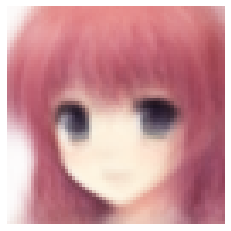

In [0]:
N_IMAGES = 10
FPI = 30
for image in tqdm(range(1000, 1000 + N_IMAGES)):
  image_0 = encoder_model(test_data[image:image+1]).numpy()[:,:100]
  image_1 = encoder_model(test_data[image + 1:image+2]).numpy()[:,:100]
  for frame in range(FPI):
    v = (image_0 * (FPI - frame) + image_1 * frame) / FPI
    img = decoder_model(v).numpy().reshape(64, 64, 3)
    plt.axis('off')
    plt.imshow(img)
    plt.savefig('frame_{:04d}.png'.format(image * FPI + frame))
    #plt.show()

In [0]:
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('frame*.png')
  filenames = sorted(filenames)
  for filename in tqdm(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
  writer.append_data(image)


In [0]:
!pip install -q imageio

In [0]:
try:
   from google.colab import files
except ImportError:
   pass
else:
   files.download(anim_file)


In [0]:
import imageio
import glob
anim_file = 'cvae.gif'